# Autocallable Phoenix Note Pricing  
## Heston Model with Calibration, Monte Carlo Simulations & Greeks

This notebook prices an **autocallable Phoenix structured product** under the **Heston stochastic volatility model**.

The workflow includes:

• Market data loading and cleaning  
• Construction of the SOFR discount curve  
• Heston model calibration to SPX option smiles  
• Monte Carlo simulation with QE scheme  
• Brownian bridge knock-in detection  
• Importance sampling and control variates  
• Pricing, Greeks, and product sensitivity analysis  



## 1. Imports & Global Configuration

This section defines:

• Python libraries  
• Market reference data  
• Calibration and Monte Carlo parameters  

### Market Setup

The underlying index spot is:

$$
S_0 = 6792.62
$$

The initial valuation date is:

$$
t_0 = \text{19 December 2025}
$$

The interest rate curve is built from **USD SOFR zero rates**.

### Heston Model Parameters

The Heston dynamics under the risk-neutral measure are:

$$
\begin{aligned}
dS_t &= (r_t - q) S_t \, dt + \sqrt{v_t} S_t \, dW_t^S \\
dv_t &= \kappa(\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v
\end{aligned}
$$

with correlation:

$$
dW_t^S dW_t^v = \rho \, dt
$$

Default parameters are provided as a fallback when calibration fails.


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from scipy.interpolate import CubicSpline
from scipy.optimize import brentq, minimize
from scipy.stats import norm

plt.style.use("seaborn-v0_8")

#  Market & data config
S0 = 6792.62
valuation_date = pd.Timestamp("2025-12-19")
sofr_file = "forward usd sofr.csv"

min_t = 1 / 12     # min maturity used in option chain
max_t = 1.0        # max maturity used in option chain

min_open_interest = 10
min_volume = 1
max_relative_spread = 0.25  # max spread / mid

#  Heston calibration config
n_gl = 16                  # Gauss–Laguerre nodes
n_strikes_per_expiry = 30  # strikes kept per expiry
n_random_starts = 6        # multi-starts in calibration

#  Default Heston parameters (from previous calibration done on 19/12/2025)
heston_params_default = dict(
    kappa=2.06797437,
    theta=0.04430816,
    volvol=0.427564,
    rho=-0.69557741,
    v0=0.0216169,
)

#  Importance Sampling Controls
use_importance_sampling = True     # set False to disable
lambda0 = -0.08                    # adaptive tilt starting value



# This is what the rest of the notebook will use.
# Optional calibration cell will overwrite this.
heston_params = heston_params_default.copy()


## 2. Date Fractions & Black–Scholes Helpers

This section defines utility functions used throughout the notebook.

### Year Fraction Convention

We use the **ACT/365** convention:

$$
\text{YearFrac}(t_0, t_1) = \frac{\text{Days}(t_1 - t_0)}{365}
$$

### Black–Scholes Pricing

The Black–Scholes call price is:

$$
C(S,K,T,r,\sigma) = S N(d_1) - K e^{-rT} N(d_2)
$$

where:

$$
\begin{aligned}
d_1 &= \frac{\ln(S/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}} \\
d_2 &= d_1 - \sigma \sqrt{T}
\end{aligned}
$$

### Implied Volatility

Implied volatility is obtained by numerically solving:

$$
C_{\text{BS}}(\sigma) = C_{\text{market}}
$$

using Brent’s root-finding algorithm with safety checks.


In [13]:
def yearfrac_act365(d0, d1):
    """
    Compute year fraction between two dates using ACT/365 convention.
    """
    return (pd.Timestamp(d1) - pd.Timestamp(d0)).days / 365.0


def bs_call_price(S, K, T, r, sigma):
    """
    Black–Scholes European call price.
    Used only for diagnostics and implied volatility inversion.
    """
    if T <= 0 or sigma <= 0:
        return max(S - K * np.exp(-r * T), 0.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def bs_vega(S, K, T, r, sigma):
    """
    Black–Scholes vega.
    Used for weighting strikes during calibration.
    """
    if T <= 0 or sigma <= 0:
        return 0.0

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


def implied_vol_safe(price, S, K, T, r):
    """
    Compute Black–Scholes implied volatility with safety checks.
    Returns NaN if inversion fails.
    """
    if price <= 0 or T <= 0:
        return np.nan

    def f(sig):
        return bs_call_price(S, K, T, r, sig) - price

    try:
        return brentq(f, 1e-6, 5.0, maxiter=200)
    except Exception:
        return np.nan


## 3. SOFR Curve & Discount Curve

This section constructs the **risk-free discount curve**.

### Input Data

• SOFR zero-coupon rates loaded from CSV  
• Rates expressed in annualized continuously compounded form  

### Discount Factor

The discount factor at maturity $T$ is:

$$
DF(T) = e^{-r(T)\,T}
$$

where $r(T)$ is obtained via interpolation of the SOFR curve.

A lightweight `ZeroCurve` object is used to provide:

• Zero rate interpolation  
• Discount factor computation


In [14]:
def read_sofr_curve(path, val_date):
    """
    Load a SOFR zero-coupon curve from CSV and return a clean term structure.

    The function is robust to messy headers and converts:
    - dates to year fractions
    - zero rates from percent to decimal
    """
    raw = pd.read_csv(path, header=None)

    header_row = None
    for i in range(len(raw)):
        if raw.iloc[i].astype(str).str.contains("Date").any():
            header_row = i
            break
    if header_row is None:
        raise ValueError("SOFR header not found")

    zc = pd.read_csv(path, skiprows=header_row)
    zc.columns = zc.columns.str.strip().str.lower().str.replace(" ", "_")

    zc = zc[["date", "zero_rate"]].copy()
    zc["date"] = pd.to_datetime(zc["date"], errors="coerce")
    zc["zero_rate"] = (
        zc["zero_rate"].astype(str)
        .str.extract(r"([0-9]+\.?[0-9]*)")[0]
        .astype(float) / 100.0
    )

    zc = zc.dropna()
    zc["T"] = (zc["date"] - val_date).dt.days / 365.0
    zc = zc[zc["T"] > 0].sort_values("T")

    return zc[["T", "zero_rate"]].rename(columns={"zero_rate": "ZeroRate"})


class ZeroCurve:
    """
    Simple zero-coupon curve object.

    Stores a term structure of zero rates and provides:
    - zero(t): zero rate at maturity t (linear interpolation)
    - df(t): discount factor exp(-r(t) * t)
    """
    def __init__(self, T, zero_rate):
        self.T = np.array(T)
        self.z = np.array(zero_rate)

    def zero(self, t):
        """
        Interpolated zero rate at maturity t.
        """
        return np.interp(t, self.T, self.z)

    def df(self, t):
        """
        Discount factor at maturity t.
        """
        return np.exp(-self.zero(t) * t)


# Build rate structures once
zc = read_sofr_curve(sofr_file, valuation_date)
r_spline = CubicSpline(zc["T"], zc["ZeroRate"])
disc_curve = ZeroCurve(zc["T"].values, zc["ZeroRate"].values)


## 4. Heston Characteristic Function & Call Pricing

European option prices under Heston are computed using **Fourier inversion**.

### Characteristic Function

Let $X_T = \ln(S_T)$.  
The characteristic function is:

$$
\phi(u) = \mathbb{E}\left[e^{iuX_T}\right]
$$

It admits a closed-form expression involving:

• Mean reversion $\kappa$  
• Long-run variance $\theta$  
• Vol of vol $\sigma$  
• Correlation $\rho$  
• Initial variance $v_0$

### Call Price Formula

The call price is recovered via:

$$
C = S_0 P_1 - K e^{-rT} P_2
$$

with probabilities $P_1$ and $P_2$ computed using **Gauss–Laguerre quadrature**.

This method is numerically stable and efficient for calibration.


In [15]:
# Gauss–Laguerre nodes (global for Heston pricing)
_gl_xs, _gl_ws = np.polynomial.laguerre.laggauss(n_gl)


def heston_cf(u, S, T, r, kappa, theta, sigma, rho, v0):
    """
    Characteristic function of log-price under the Heston model.
    """
    i = 1j
    a = kappa * theta
    b = kappa

    d = np.sqrt((rho * sigma * i * u - b)**2 + sigma**2 * (u*u + i*u))
    g = (b - rho * sigma * i * u - d) / (b - rho * sigma * i * u + d)

    C = r * i * u * T + (a / sigma**2) * (
        (b - rho * sigma * i * u - d) * T
        - 2 * np.log((1 - g * np.exp(-d*T)) / (1 - g))
    )

    D = ((b - rho * sigma * i * u - d) / sigma**2) * (
        (1 - np.exp(-d*T)) / (1 - g * np.exp(-d*T))
    )

    return np.exp(C + D * v0 + i * u * np.log(S))


def heston_call_price(S, K, T, r, kappa, theta, sigma, rho, v0):
    """
    Price a European call under the Heston model using
    Fourier inversion with Gauss–Laguerre quadrature.
    """
    if T <= 0:
        return max(S - K, 0.0)

    i = 1j
    x = np.log(K)
    phi_mi = heston_cf(-i, S, T, r, kappa, theta, sigma, rho, v0)

    def P(j):
        s = 0.0
        for u, w in zip(_gl_xs, _gl_ws):
            if j == 1:
                phi = heston_cf(u - i, S, T, r, kappa, theta, sigma, rho, v0) / phi_mi
            else:
                phi = heston_cf(u, S, T, r, kappa, theta, sigma, rho, v0)

            s += w * np.exp(u) * np.real(np.exp(-i * u * x) * phi / (i * u))
        return 0.5 + s / np.pi

    return S * P(1) - K * np.exp(-r * T) * P(2)


## 5. SPX Option Chain & OTM Dataset Construction

SPX option chains are downloaded from **Yahoo Finance**.

### Liquidity Filters

Options are filtered using:

• Minimum open interest  
• Minimum volume  
• Maximum relative bid–ask spread  

### OTM Call-Equivalent Transformation

Put–call parity is used:

$$
C - P = DF \cdot (F - K)
$$

All quotes are transformed into **OTM call equivalents**, which:

• Improves numerical stability  
• Avoids deep ITM options  
• Produces a clean volatility smile


In [16]:
def load_spx_yahoo(val_date=valuation_date):
    """
    Load SPX option chains from Yahoo Finance and apply liquidity filters.
    """
    spx = yf.Ticker("^SPX")
    rows = []

    for exp in spx.options:
        expiry = pd.Timestamp(exp)
        T = yearfrac_act365(val_date, expiry)
        if T < min_t or T > max_t:
            continue

        chain = spx.option_chain(exp)
        calls = chain.calls.copy()
        puts = chain.puts.copy()

        calls["type"] = "C"
        puts["type"] = "P"

        df = pd.concat([calls, puts])
        df["Expiry"] = expiry
        df["T"] = T
        rows.append(df)

    options_chain = pd.concat(rows)
    options_chain = options_chain.rename(columns={"strike": "K"})
    options_chain["bid"] = pd.to_numeric(options_chain["bid"], errors="coerce")
    options_chain["ask"] = pd.to_numeric(options_chain["ask"], errors="coerce")
    options_chain["mid"] = 0.5 * (options_chain["bid"] + options_chain["ask"])
    options_chain["spread"] = options_chain["ask"] - options_chain["bid"]

    # Liquidity filters
    options_chain = options_chain[
        (options_chain["bid"] > 0) & (options_chain["ask"] > 0)
    ]
    options_chain = options_chain[
        (options_chain["openInterest"] >= min_open_interest)
        | (options_chain["volume"] >= min_volume)
    ]
    options_chain = options_chain[
        options_chain["spread"] <= max_relative_spread * options_chain["mid"]
    ]

    return options_chain[["Expiry", "T", "K", "type", "mid", "spread"]]


def build_otm_dataset(options_chain, r_spline):
    """
    Convert call and put prices into an OTM call-equivalent dataset
    using put–call parity.
    """
    df = options_chain.copy()

    # attach rates and discount factors
    df["r"] = r_spline(df["T"].values)
    df["DF"] = np.exp(-df["r"] * df["T"])

    calls = df[df["type"] == "C"]
    puts = df[df["type"] == "P"]

    merged = calls.merge(
        puts,
        on=["Expiry", "T", "K"],
        suffixes=("_C", "_P")
    )

    # recompute DF explicitly after merge
    merged["DF"] = np.exp(-merged["r_C"] * merged["T"])

    # forward via put–call parity
    merged["F"] = merged["K"] + (merged["mid_C"] - merged["mid_P"]) / merged["DF"]

    # OTM call equivalent
    merged["Call_OTM"] = np.where(
        merged["K"] >= merged["F"],
        merged["mid_C"],
        merged["mid_P"] + merged["DF"] * (merged["F"] - merged["K"])
    )

    merged["Spread_OTM"] = np.where(
        merged["K"] >= merged["F"],
        merged["spread_C"],
        merged["spread_P"]
    )

    otm_dataset = merged[
        ["Expiry", "T", "K", "r_C", "DF", "F", "Call_OTM", "Spread_OTM"]
    ].rename(columns={"r_C": "r"})

    return otm_dataset


## 6. Heston Calibration in Implied Volatility Space

The Heston parameters are calibrated by minimizing:

$$
\text{RMSE} = \sqrt{
\frac{\sum_i w_i (\sigma_i^{\text{model}} - \sigma_i^{\text{market}})^2}
{\sum_i w_i}
}
$$

### Weighting Scheme

Weights are defined as:

$$
w_i = \frac{1}{\text{Spread}_i^2 \cdot \text{Vega}_i}
$$

This ensures:

• Less weight on illiquid options  
• Stability around ATM strikes  

### Optimization

• Multi-start L-BFGS-B optimization  
• Hard parameter constraints  
• Fallback to default parameters if calibration fails


In [17]:
def calibrate_heston_vol_space(otm_df):
    """
    Calibrate Heston parameters by minimizing RMSE in implied–volatility space.

    Objective:
       minimize sqrt( sum_i w_i * (IV_heston - IV_market)^2 / sum_i w_i )
    """

    Ks = otm_df["K"].values
    Ts = otm_df["T"].values
    rs = otm_df["r"].values
    iv_mkt = otm_df["IV_mkt"].values
    spreads = otm_df["Spread_OTM"].values

    # Vega weighting to downweight low-vega strikes (more stable)
    vega = np.array([
        bs_vega(S0, K, T, r, vol)
        for K, T, r, vol in zip(Ks, Ts, rs, iv_mkt)
    ])

    # Robust weights: penalize wide spreads and tiny vegas
    # (keep same spirit as your function, but numerically safer)
    w = 1.0 / (np.maximum(spreads, 1e-3)**2 * np.maximum(vega, 1e-6))
    w /= w.mean()

    def objective(params):
        kappa, theta, sigma, rho, v0 = params

        # hard constraints
        if kappa <= 0 or theta <= 0 or sigma <= 0 or v0 <= 0:
            return 1e6
        if abs(rho) >= 1.0:
            return 1e6

        iv_model = np.empty_like(iv_mkt)
        for i, (K, T, r) in enumerate(zip(Ks, Ts, rs)):
            p = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
            ivm = implied_vol_safe(p, S0, K, T, r)
            iv_model[i] = ivm

        # If inversion fails for any point -> reject strongly
        if np.any(~np.isfinite(iv_model)):
            return 1e6

        diff = iv_model - iv_mkt
        return np.sqrt(np.sum(w * diff**2) / np.sum(w))

    bounds = [(0.2, 15), (1e-4, 0.3), (1e-3, 3), (-0.99, 0.0), (1e-4, 0.3)]

    best_val = np.inf
    best = None

    # diversified starts (still 6 as in your global config)
    rng = np.random.default_rng(123)
    for j in range(n_random_starts):
        if j == 0:
            x0 = np.array([2.0, 0.04, 0.6, -0.6, 0.04])
        else:
            x0 = np.array([
                rng.uniform(bounds[0][0], bounds[0][1]),
                rng.uniform(bounds[1][0], bounds[1][1]),
                rng.uniform(bounds[2][0], bounds[2][1]),
                rng.uniform(bounds[3][0], bounds[3][1]),
                rng.uniform(bounds[4][0], bounds[4][1]),
            ])

        res = minimize(objective, x0, bounds=bounds, method="L-BFGS-B")

        if np.isfinite(res.fun) and res.fun < best_val:
            best_val = res.fun
            best = res.x

    return best, best_val


Optional: run calibration + vol surface plots

In [ ]:

# Heston Calibration on ~200 Quotes


import time
t0 = time.time()
print("\n Loading SPX option chain...")

# Load raw chain
options_chain = load_spx_yahoo()

if options_chain.empty:
    print(" No option chain loaded – fallback to DEFAULT parameters.")
    heston_params = heston_params_default.copy()
    obj = None

else:
    print("Building OTM call-equivalent dataset...")
    tmp = build_otm_dataset(options_chain, r_spline)
    options_otm = tmp[0] if isinstance(tmp, tuple) else tmp

    print("Computing implied vols...")
    options_otm["IV_mkt"] = [
        implied_vol_safe(price, S0, K, T, r)
        for price, K, T, r in zip(
            options_otm["Call_OTM"], options_otm["K"], options_otm["T"], options_otm["r"]
        )
    ]
    options_otm = options_otm.dropna(subset=["IV_mkt"]).copy()

    # basic cleaning
    options_otm["mny"] = options_otm["K"] / S0
    options_otm = options_otm[
        (options_otm["Call_OTM"] > 0.0)
        & (options_otm["Spread_OTM"] > 0.0)
        & ((options_otm["Spread_OTM"] / options_otm["Call_OTM"]) < 0.25)
        & (options_otm["IV_mkt"] > 1e-4)
        & (options_otm["IV_mkt"] < 1.50)
        & (options_otm["mny"] >= 0.65)
        & (options_otm["mny"] <= 1.35)
    ].copy()

    if options_otm.empty:
        print(" Market dataset empty – using DEFAULT.")
        heston_params = heston_params_default.copy()
        obj = None

    else:
        print("Selecting diversified calibration slice...")

        # Selection per expiry:
        # - keep a solid ATM core (stability for theta/v0)
        # - add more OTM wings (smile fit + Phoenix sensitivity)
        def pick_strikes(df):
            df = df.sort_values("K").copy()
            if len(df) <= 12:
                return df

            # Use forward-based log-moneyness to define wings
            # (F is already in your OTM dataset)
            df["log_m"] = np.log(df["K"] / df["F"])

            # ATM core: smallest |log_m|
            atm = df.reindex(df["log_m"].abs().sort_values().index).head(8)

            # Wings: largest |log_m|, but keep liquid points (small spreads)
            wings = df.reindex(df["log_m"].abs().sort_values(ascending=False).index)

            # Favor wings but avoid ultra-bad spreads: sort by (|log_m|, spread)
            wings = wings.sort_values(["log_m"], key=lambda s: s.abs(), ascending=False)
            wings = wings.sort_values("Spread_OTM").head(16)

            out = pd.concat([atm, wings], ignore_index=True)
            out = out.drop_duplicates(subset=["K"])

            return out

        cal_slice = (
            options_otm
            .groupby("Expiry", group_keys=False)
            .apply(pick_strikes, include_groups=False)
            .reset_index(drop=True)
        )

        # Cap to 200 quotes, but keep maturity diversification
        # Take the most liquid first (small spread), then cap
        cal_slice = cal_slice.sort_values(["Spread_OTM", "T", "K"]).head(200).copy()
        print(f"Final calibration dataset = {len(cal_slice)} quotes")

        if len(cal_slice) < 60:
            print(" NOT ENOUGH DATA – using DEFAULT params")
            heston_params = heston_params_default.copy()
            obj = None

        else:
            print("Running optimization... (6 random starts)")
            params, obj = calibrate_heston_vol_space(cal_slice)

            if (params is None) or (not np.all(np.isfinite(params))):
                print(" Calibration failed – using DEFAULT")
                heston_params = heston_params_default.copy()
                obj = None
            else:
                kappa, theta, volvol, rho, v0 = params
                heston_params = dict(
                    kappa=float(kappa),
                    theta=float(theta),
                    volvol=float(volvol),
                    rho=float(rho),
                    v0=float(v0),
                )

t1 = time.time()
print("\n Heston parameters used")
for k, v in heston_params.items():
    print(f"{k:7} = {v:.8f}")
print(f"Objective RMSE (IV): {obj}")
print(f"Calibration time: {t1 - t0: .2f} seconds\n")




kappa   = 6.06711163
theta   = 0.12160208
volvol  = 3.00000000
rho     = -0.91290952
v0      = 0.11139999

In [ ]:
# Smile plots

if obj is None:
    print("No calibrated slice available (obj is None). Run calibration first.")
else:
    # choose up to 6 maturities spread across the available set
    unique_T = np.sort(cal_slice["T"].unique())
    if len(unique_T) > 1:
        idxs = np.linspace(0, len(unique_T) - 1, min(100, len(unique_T))).astype(int)
        T_list = unique_T[idxs]
    else:
        T_list = unique_T

    for T0 in T_list:
        sl = cal_slice[np.isclose(cal_slice["T"], T0)].sort_values("K")

        plt.figure(figsize=(9, 5))
        plt.plot(sl["K"], sl["IV_mkt"], marker="o", linestyle="-", label=f"Market T={T0:.2f}")
        plt.plot(sl["K"], sl["IV_heston"], marker="x", linestyle="--", label=f"Heston T={T0:.2f}")
        plt.xlabel("Strike")
        plt.ylabel("Implied Volatility")
        plt.title(f"Smile at maturity T={T0:.2f}")
        plt.grid(True)
        plt.legend()
        plt.show()


## 7. Heston Monte Carlo Simulation (QE Scheme)

Paths are simulated using the **Quadratic-Exponential (QE)** scheme.

### Advantages

• Positivity of variance  
• High accuracy  
• Widely used in production  

### Importance Sampling

An adaptive exponential tilting is applied:

$$
\lambda(t) = \lambda_0 e^{-t/T}
$$

This improves rare-event estimation such as:

• Knock-in barrier hits  
• Autocall probabilities  

Likelihood ratios are tracked to ensure unbiased pricing.


In [19]:
def simulate_heston_qe_mc(
    S0, v0, kappa, theta, sigma, rho,
    T, r_curve, q,
    n_steps, n_paths,
    seed=0, antithetic=True,
    use_is=False, lambda0=-0.10
):
    """
    Heston Monte-Carlo using Quadratic-Exponential scheme
    + Optional adaptive exponential tilting importance sampling:

        lambda(t) = lambda0 * exp(-t / T)

    Adaptive IS:
      • stronger early (helps KI detection)
      • fades to 0 near maturity (prevents weight collapse)
    """
    rng = np.random.default_rng(seed)

    dt = T / n_steps
    tgrid = np.linspace(0.0, T, n_steps + 1)

    # ANTHETIC RANDOMS
    if antithetic:
        assert n_paths % 2 == 0
        half = n_paths // 2
        Z1 = rng.standard_normal((half, n_steps))
        Z2 = rng.standard_normal((half, n_steps))
        Z1 = np.vstack([Z1, -Z1])
        Z2 = np.vstack([Z2, -Z2])
    else:
        Z1 = rng.standard_normal((n_paths, n_steps))
        Z2 = rng.standard_normal((n_paths, n_steps))

    dWv = np.sqrt(dt) * Z1
    dWs = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

    S = np.zeros((n_paths, n_steps + 1))
    v = np.zeros((n_paths, n_steps + 1))
    Iv = np.zeros((n_paths, n_steps))

    S[:, 0] = S0
    v[:, 0] = v0
    exp_kdt = np.exp(-kappa * dt)
    psi_c = 1.5

    # LOG-WEIGHTS FOR IS
    logW = np.zeros(n_paths)

    for i in range(n_steps):
        t_mid = 0.5 * (tgrid[i] + tgrid[i+1])
        r = r_curve.zero(t_mid)

        v_t = v[:, i]

        # variance conditional stats
        m = theta + (v_t - theta) * exp_kdt
        s2 = (
            v_t * sigma**2 * exp_kdt / kappa * (1 - exp_kdt)
            + theta * sigma**2 / (2 * kappa) * (1 - exp_kdt)**2
        )
        psi = s2 / np.maximum(m**2, 1e-12)
        v_next = np.zeros_like(v_t)

        # QE regime 1
        idx = psi <= psi_c
        b2 = 2 / psi[idx] - 1 + np.sqrt(2 / psi[idx]) * np.sqrt(2 / psi[idx] - 1)
        a = m[idx] / (1 + b2)
        Zv = dWv[idx, i] / np.sqrt(dt)
        v_next[idx] = a * (np.sqrt(b2) + Zv)**2

        # QE regime 2
        idx2 = ~idx
        p = (psi[idx2] - 1) / (psi[idx2] + 1)
        beta = (1 - p) / m[idx2]
        U = rng.random(np.sum(idx2))
        v_next[idx2] = np.where(
            U <= p,
            0.0,
            -np.log((1 - p) / (1 - U)) / beta
        )

        v[:, i+1] = np.maximum(v_next, 0.0)

        # integrated variance
        Iv[:, i] = 0.5 * (v[:, i] + v[:, i+1]) * dt

        # BASE SHOCK
        Zs_base = dWs[:, i] / np.sqrt(dt)

        if use_is and lambda0 != 0.0:
            # compute adaptive lambda(t)
            lambda_t = lambda0 * np.exp(-t_mid / T)

            Zs = Zs_base + lambda_t

            # likelihood log-weight increment
            logW += -lambda_t * Zs + 0.5 * (lambda_t**2)
        else:
            Zs = Zs_base

        S[:, i+1] = S[:, i] * np.exp(
            (r - q) * dt - 0.5 * Iv[:, i] + np.sqrt(Iv[:, i]) * Zs
        )

    weights = np.exp(logW) if use_is else np.ones(n_paths)
    return S, Iv, tgrid, weights


## 8. Brownian Bridge Knock-In Detection

Barrier events are detected using a **Brownian bridge correction**.

### Motivation

Discrete monitoring underestimates barrier hits.  
Brownian bridge restores **continuous-time accuracy**.

### Down-Crossing Probability

The crossing probability between two dates is:

$$
\mathbb{P}(\text{hit}) =
\exp\left(
-\frac{2 \ln(S_a/B)\ln(S_b/B)}{\int v_t dt}
\right)
$$

This is applied pathwise using uniform random draws.


In [20]:
def bb_down_cross_prob(Sa, Sb, B, var):
    """
    Brownian bridge probability that a continuous-time log-price process
    crosses a down barrier B between two observation times.
    """
    hit = np.zeros_like(Sa)

    # If the barrier is already breached at either endpoint
    breached = (Sa <= B) | (Sb <= B)
    hit[breached] = 1.0

    # Brownian bridge probability for paths that stay above at endpoints
    ok = ~breached
    x = np.log(Sa[ok] / B)
    y = np.log(Sb[ok] / B)

    hit[ok] = np.exp(-2.0 * x * y / np.maximum(var[ok], 1e-12))

    return np.clip(hit, 0.0, 1.0)


def ki_hit_bridge(S, Iv, S0, ki):
    """
    Detect knock-in (KI) barrier hits using a Brownian bridge correction.

    Returns
    -------
    hit : ndarray (bool)
        Boolean array indicating whether the KI barrier was hit per path
    """
    B = ki * S0
    rng = np.random.default_rng(123)

    # One uniform draw per path and per time step
    U = rng.random(Iv.shape)

    hit = np.zeros(S.shape[0], dtype=bool)

    for i in range(Iv.shape[1]):
        p = bb_down_cross_prob(
            S[:, i],
            S[:, i+1],
            B,
            Iv[:, i]
        )
        hit |= (U[:, i] < p)

    return hit


## 9. Phoenix Payoff Definition

The Phoenix note has:

• Monthly observation dates  
• Autocall feature  
• Coupon with memory  
• Down-and-in barrier  

### Coupon

At each observation date $t_j$:

$$
\text{Coupon}_j =
\begin{cases}
c \cdot (1 + \text{missed}) & \text{if } S_{t_j} \ge B_c S_0 \\
0 & \text{otherwise}
\end{cases}
$$

### Autocall

If:

$$
S_{t_j} \ge B_a S_0
$$

the product redeems early at par.

### Final Redemption

• No knock-in: full notional  
• Knock-in: equity-linked payoff  

$$
\min\left(1, \frac{S_T}{S_0}\right)
$$


In [21]:
def price_phoenix_mc(
    S, Iv, tgrid, disc_curve,
    S0,
    obs_times,
    call_barriers,
    coupon_barriers,
    coupon,
    ki,
    notional=100.0,
    memory=True
):
    """
    Price an autocallable Phoenix note using Monte Carlo simulation.
    """
    n_paths = S.shape[0]

    # Map observation times to closest simulation indices
    obs_idx = [np.argmin(np.abs(tgrid - t)) for t in obs_times]

    # Detect knock-in events using Brownian bridge correction
    ki_hit = ki_hit_bridge(S, Iv, S0, ki)

    pv = np.zeros(n_paths)
    alive = np.ones(n_paths, dtype=bool)
    missed = np.zeros(n_paths)

    for j, idx in enumerate(obs_idx):
        t = tgrid[idx]
        df = disc_curve.df(t)
        Sobs = S[:, idx]

        # Coupon condition
        cpn_hit = (Sobs >= coupon_barriers[j] * S0) & alive

        if memory:
            pv += df * notional * coupon * (missed + 1) * cpn_hit
            missed[alive & ~cpn_hit] += 1
            missed[cpn_hit] = 0
        else:
            pv += df * notional * coupon * cpn_hit

        # Autocall condition
        call_hit = (Sobs >= call_barriers[j] * S0) & alive
        pv += df * notional * call_hit
        alive[call_hit] = False

    # Final redemption at maturity
    ST = S[:, -1]
    dfT = disc_curve.df(tgrid[-1])

    # No knock-in: full capital protection
    pv += dfT * notional * alive * (~ki_hit)

    # Knock-in: equity-linked redemption
    pv += dfT * notional * alive * ki_hit * np.minimum(1.0, ST / S0)

    return pv


## 10. Control Variate Estimator

A control variate is used to reduce variance.

### Control Variable

$$
X = DF(T) \cdot S_T
$$

with known expectation:

$$
\mathbb{E}[X] = S_0 e^{-qT}
$$

### Adjusted Estimator

$$
\hat{V} = V - \beta (X - \mathbb{E}[X])
$$

This significantly improves Monte Carlo efficiency.


In [22]:
def phoenix_price_with_cv(pv, S, disc_curve, T, q, weights=None):
    """
    Compute the final Monte Carlo price of the Phoenix note
    using a control variate to reduce variance.

    Control variate: discounted terminal spot X = DF(T) * S_T
    with known expectation EX = S0 * exp(-q*T).

    If weights is not None, we perform a weighted estimator
    to support importance sampling.
    """
    ST = S[:, -1]
    dfT = disc_curve.df(T)

    # Control variate and its expectation
    X = dfT * ST
    EX = S0 * np.exp(-q * T)

    if weights is None:
        #  unweighted case (no IS), same as before
        beta = np.cov(pv, X)[0, 1] / np.var(X)

        pv_adj = pv - beta * (X - EX)

        price = pv_adj.mean()
        stderr = pv_adj.std(ddof=1) / np.sqrt(len(pv_adj))
        return price, stderr

    #  weighted case (importance sampling)
    w = np.asarray(weights)
    w_sum = w.sum()

    # weighted means
    mean_pv = np.sum(w * pv) / w_sum
    mean_X = np.sum(w * X) / w_sum

    # weighted covariance and variance
    cov_pv_X = np.sum(w * (pv - mean_pv) * (X - mean_X)) / w_sum
    var_X = np.sum(w * (X - mean_X)**2) / w_sum

    beta = cov_pv_X / var_X

    pv_adj = pv - beta * (X - EX)

    # weighted estimator
    price = np.sum(w * pv_adj) / w_sum

    # approximate effective sample size
    n_eff = w_sum**2 / np.sum(w**2)
    var_adj = np.sum(w * (pv_adj - price)**2) / w_sum
    stderr = np.sqrt(var_adj / max(n_eff - 1.0, 1.0))

    return price, stderr


Baseline Phoenix pricing (using calibrated-or-default Heston)

In [23]:
# Unpack Heston parameters (either default or from calibration cell)
kappa = heston_params["kappa"]
theta = heston_params["theta"]
volvol = heston_params["volvol"]
rho = heston_params["rho"]
v0 = heston_params["v0"]

# Product specification
T_phoenix = 2.0
obs_times = np.linspace(1/12, T_phoenix, 24)

call_barriers = np.ones_like(obs_times) * 1.00
coupon_barriers = np.ones_like(obs_times) * 0.70
coupon = 0.01
ki = 0.60
notional = 100.0
memory = True
q = 0.0  # dividend yield

# Monte Carlo controls
n_steps = int(252 * T_phoenix)
n_paths = 200_000
seed = 42

# Simulate Heston paths once (with optional importance sampling)
S_mc, Iv_mc, tgrid, weights_mc = simulate_heston_qe_mc(
    S0=S0,
    v0=v0,
    kappa=kappa,
    theta=theta,
    sigma=volvol,
    rho=rho,
    T=T_phoenix,
    r_curve=disc_curve,
    q=q,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=seed,
    antithetic=True,
    use_is=use_importance_sampling,
    lambda0=lambda0,
)

# Phoenix payoff
pv = price_phoenix_mc(
    S_mc, Iv_mc, tgrid, disc_curve,
    S0,
    obs_times,
    call_barriers,
    coupon_barriers,
    coupon,
    ki,
    notional=notional,
    memory=memory
)

price_base, err_base = phoenix_price_with_cv(
    pv, S_mc, disc_curve, T_phoenix, q=q, weights=weights_mc
)

print(" Phoenix baseline price (MC + CV) ")
print(f"Price  : {price_base:.4f} per {notional}")
print(f"StdErr : {err_base:.4f}")


 Phoenix baseline price (MC + CV) 
Price  : 103.7357 per 100.0
StdErr : 0.0413


## 11. Greeks Computation

Greeks are computed using:

• Common Random Numbers  
• Antithetic variates  
• Control variates  

### Delta & Gamma

Spot is bumped by ±1%:

$$
\Delta = \frac{V(S+h) - V(S-h)}{2h}
$$

$$
\Gamma = \frac{V(S+h) - 2V(S) + V(S-h)}{h^2}
$$

### Vega, Vanna, Volga

Variance is bumped via:

$$
\sigma_0 = \sqrt{v_0}
$$

with re-simulation under bumped volatility.


In [24]:
"""Greeks (CRN + antithetic + control variate : bumping spot & spot vol sigma0 = sqrt(v0))
Corrected: keep contractual S0_ref FIXED when bumping spot, so barriers do not move with the bump.
"""

def phoenix_price_cached(S_paths, Iv_paths, weights_paths, S0_ref):
    """
    Price Phoenix using already simulated paths + weights.
    S0_ref is the contractual reference level used in payoff definition
    (barriers, KI level, and ST/S0 ratio). For spot Greeks, this must stay fixed.
    """
    pv_local = price_phoenix_mc(
        S_paths, Iv_paths, tgrid, disc_curve,
        S0_ref,
        obs_times,
        call_barriers,
        coupon_barriers,
        coupon,
        ki,
        notional=notional,
        memory=memory
    )
    return phoenix_price_with_cv(
        pv_local, S_paths, disc_curve, T_phoenix, q=q, weights=weights_paths
    )[0]


#  FINITE DIFFERENCE SCALES
epsS = 0.01      # ±1% spot bump
eps_vol = 0.05   # ±5% bump to spot vol sigma0 = sqrt(v0)

hS = epsS * S0
sigma0 = np.sqrt(v0)
h_vol = eps_vol * sigma0

P0 = price_base

# Contractual reference level (fixed for the payoff definition)
S0_contract = S0


#  DELTA & GAMMA (NO RESIMULATION)
# Bump spot by scaling the simulated paths, but DO NOT bump S0_ref in the payoff.
S_up = S_mc * ((S0 + hS) / S0)
S_dn = S_mc * ((S0 - hS) / S0)

P_upS = phoenix_price_cached(S_up, Iv_mc, weights_mc, S0_contract)
P_dnS = phoenix_price_cached(S_dn, Iv_mc, weights_mc, S0_contract)

delta = (P_upS - P_dnS) / (2.0 * hS)
gamma = (P_upS - 2.0 * P0 + P_dnS) / (hS ** 2)


#  VEGA & VOLGA (RE-SIM WRT SPOT VOL sigma0)
# Here we bump sigma0 (= sqrt(v0)), resimulate under bumped v0, and keep payoff S0_ref fixed.
sigma0_up = sigma0 + h_vol
sigma0_dn = max(sigma0 - h_vol, 1e-8)

v0_up = sigma0_up**2
v0_dn = sigma0_dn**2

S_vup, Iv_vup, _, w_vup = simulate_heston_qe_mc(
    S0=S0, v0=v0_up,
    kappa=kappa, theta=theta, sigma=volvol, rho=rho,
    T=T_phoenix, r_curve=disc_curve, q=q,
    n_steps=n_steps, n_paths=n_paths,
    seed=seed, antithetic=True,
    use_is=use_importance_sampling,
    lambda0=lambda0,
)
S_vdn, Iv_vdn, _, w_vdn = simulate_heston_qe_mc(
    S0=S0, v0=v0_dn,
    kappa=kappa, theta=theta, sigma=volvol, rho=rho,
    T=T_phoenix, r_curve=disc_curve, q=q,
    n_steps=n_steps, n_paths=n_paths,
    seed=seed, antithetic=True,
    use_is=use_importance_sampling,
    lambda0=lambda0,
)

P_vup = phoenix_price_cached(S_vup, Iv_vup, w_vup, S0_contract)
P_vdn = phoenix_price_cached(S_vdn, Iv_vdn, w_vdn, S0_contract)

vega  = (P_vup - P_vdn) / (2.0 * h_vol)
volga = (P_vup - 2.0 * P0 + P_vdn) / (h_vol ** 2)


#  VANNA (CROSS OF SPOT & SPOT VOL)
# Spot bump is applied by scaling paths; payoff reference S0_ref stays fixed.
S_vup_upS = S_vup * ((S0 + hS) / S0)
S_vup_dnS = S_vup * ((S0 - hS) / S0)
S_vdn_upS = S_vdn * ((S0 + hS) / S0)
S_vdn_dnS = S_vdn * ((S0 - hS) / S0)

P_sp_vp = phoenix_price_cached(S_vup_upS, Iv_vup, w_vup, S0_contract)
P_sp_vm = phoenix_price_cached(S_vdn_upS, Iv_vdn, w_vdn, S0_contract)
P_sm_vp = phoenix_price_cached(S_vup_dnS, Iv_vup, w_vup, S0_contract)
P_sm_vm = phoenix_price_cached(S_vdn_dnS, Iv_vdn, w_vdn, S0_contract)

vanna = (P_sp_vp - P_sp_vm - P_sm_vp + P_sm_vm) / (4.0 * hS * h_vol)


#  RESULTS
print(" Phoenix Greeks (per 100 notional) ")
print(f"Delta : {delta:.6f}")
print(f"Gamma : {gamma:.8f}")
print(f"Vega  : {vega:.6f}   (wrt spot vol sigma0 = sqrt(v0))")
print(f"Vanna : {vanna:.6f}  (cross S & sigma0)")
print(f"Volga : {volga:.6f}  (wrt sigma0)")


 Phoenix Greeks (per 100 notional) 
Delta : -0.013332
Gamma : 0.00004112
Vega  : 2.127508   (wrt spot vol sigma0 = sqrt(v0))
Vanna : 0.058109  (cross S & sigma0)
Volga : -52.236081  (wrt sigma0)


## 12. Sensitivity Analysis

The Phoenix price is analyzed against:

• Coupon barrier  
• Knock-in barrier  
• Coupon level  
• Autocall barrier  

All sensitivities are computed using:

• Same simulated paths  
• Same importance sampling weights  

This ensures stable and unbiased comparisons.


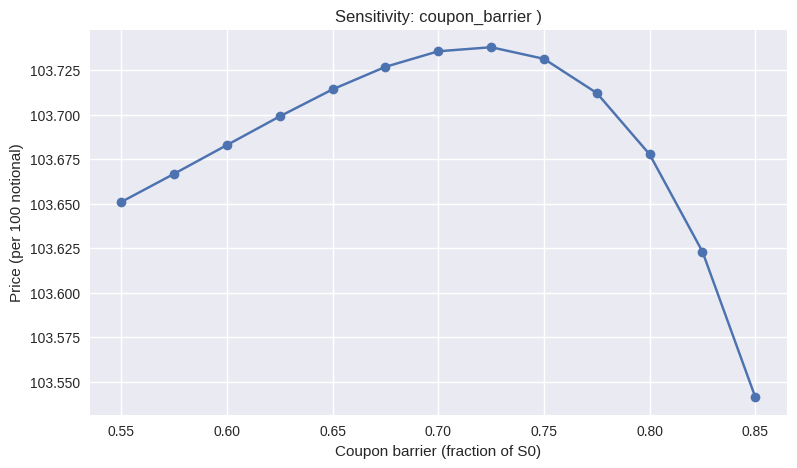

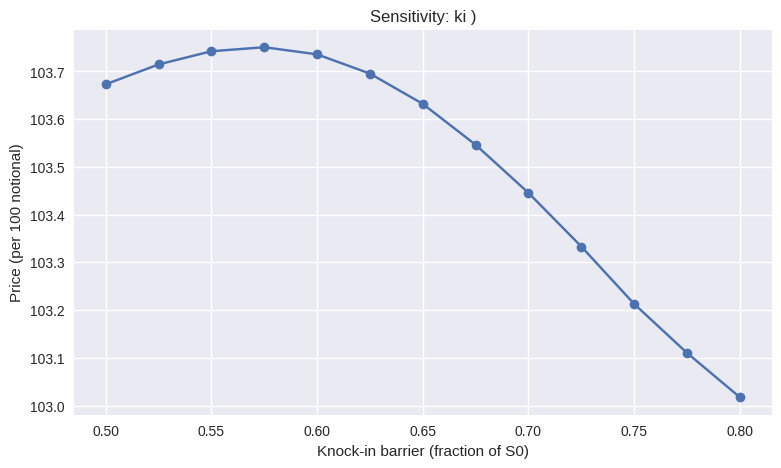

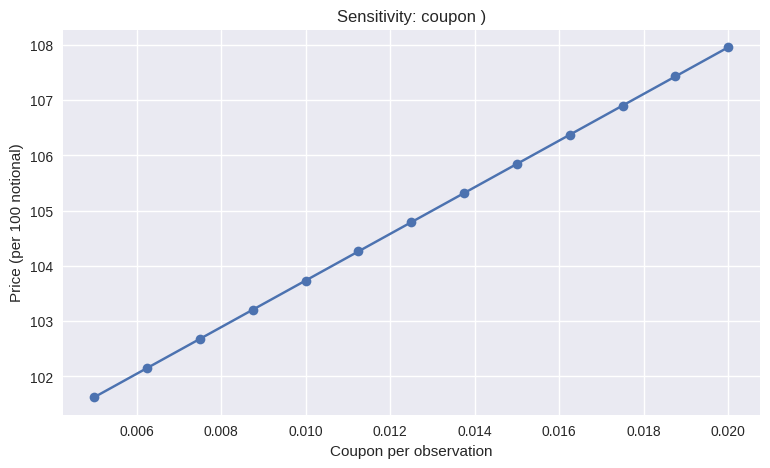

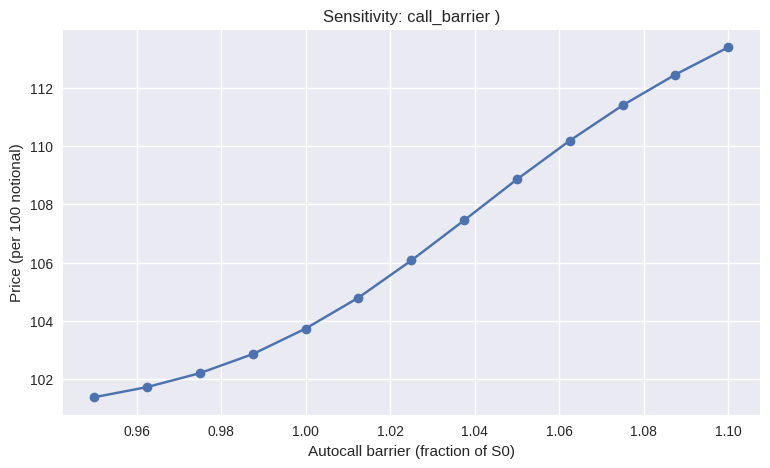

,param,value,price
0,coupon_barrier,0.550,103.650975
1,coupon_barrier,0.575,103.666815
2,coupon_barrier,0.600,103.682990
3,coupon_barrier,0.625,103.699121
4,coupon_barrier,0.650,103.714305
5,coupon_barrier,0.675,103.726974
6,coupon_barrier,0.700,103.735722
7,coupon_barrier,0.725,103.738001
8,coupon_barrier,0.750,103.731468
9,coupon_barrier,0.775,103.712242


In [25]:
def reprice_from_cached_terms(call_level=None, coupon_level=None, cpn_bar=None, ki_level=None):
    """
    Reprices the Phoenix using the *same simulated paths* AND *same weights*
    — so results stay stable and unbiased whether importance sampling is ON or OFF.
    """
    call_barriers_tmp = call_barriers.copy()
    coupon_barriers_tmp = coupon_barriers.copy()
    coupon_tmp = coupon
    ki_tmp = ki

    if call_level is not None:
        call_barriers_tmp[:] = float(call_level)
    if cpn_bar is not None:
        coupon_barriers_tmp[:] = float(cpn_bar)
    if coupon_level is not None:
        coupon_tmp = float(coupon_level)
    if ki_level is not None:
        ki_tmp = float(ki_level)

    pv_tmp = price_phoenix_mc(
        S_mc, Iv_mc, tgrid, disc_curve,
        S0, obs_times,
        call_barriers_tmp, coupon_barriers_tmp,
        coupon_tmp, ki_tmp,
        notional=notional, memory=memory
    )

    # weighted control variate adjustment
    return phoenix_price_with_cv(
        pv_tmp, S_mc, disc_curve, T_phoenix, q=q, weights=weights_mc
    )[0]


#  Sensitivity grids
grid_coupon_barrier = np.linspace(0.55, 0.85, 13)
grid_ki             = np.linspace(0.50, 0.80, 13)
grid_coupon         = np.linspace(0.005, 0.020, 13)
grid_call_barrier   = np.linspace(0.95, 1.10, 13)

sens_rows = []

for x in grid_coupon_barrier:
    sens_rows.append(("coupon_barrier", x, reprice_from_cached_terms(cpn_bar=x)))

for x in grid_ki:
    sens_rows.append(("ki", x, reprice_from_cached_terms(ki_level=x)))

for x in grid_coupon:
    sens_rows.append(("coupon", x, reprice_from_cached_terms(coupon_level=x)))

for x in grid_call_barrier:
    sens_rows.append(("call_barrier", x, reprice_from_cached_terms(call_level=x)))

sens = pd.DataFrame(sens_rows, columns=["param", "value", "price"])


#  Plot helper
def plot_sens(param, xlabel):
    sl = sens[sens["param"] == param].sort_values("value")
    plt.figure(figsize=(9, 5))
    plt.plot(sl["value"], sl["price"], marker="o")
    plt.xlabel(xlabel)
    plt.ylabel("Price (per 100 notional)")
    plt.title(f"Sensitivity: {param} )")
    plt.grid(True)
    plt.show()


plot_sens("coupon_barrier", "Coupon barrier (fraction of S0)")
plot_sens("ki", "Knock-in barrier (fraction of S0)")
plot_sens("coupon", "Coupon per observation")
plot_sens("call_barrier", "Autocall barrier (fraction of S0)")

sens.head(20)
